# <font color=orange>1) Examples : Load a game with an initial grid state and get the flows in Amperes</font>

### <font color=green>I) Initialisation, game loading.</font>

In [23]:
%run ~/Documents/pypownet-master/pypownet/grid.py
%run ~/Documents/pypownet-master/pypownet/game.py
from IPython.core.display import display, SVG

import networkx as nx

parameters_folder = "../../deesp/ressources/parameters/default14"
game_level = "level0"
chronic_looping_mode = 'natural'
chronic_starting_id = 0
game_over_mode = 'soft'

_game = Game(parameters_folder, game_level, chronic_looping_mode, chronic_starting_id,
                 game_over_mode, renderer_frame_latency=None)

mp_path_config = /home/mozgawamar/.local/lib/python3.6/site-packages/pypownet-2.0.4-py3.6.egg/matpower_path.config
relative_path =  /home/mozgawamar/Documents/matpower/matpower/


### <font color=green>II) We retrieve grid and currentflowsZZ</font>

In [24]:
_grid = _game.grid
initial_flows = _grid.extract_flows_a()
initial_flows

array([45.01181658, 23.77726765, 27.29772466, 20.86885668, 14.72299187,
        9.66009344, 26.9070113 ,  4.31850371,  4.64136691, 10.79893577,
       12.11778719,  4.92273769,  6.69043283, 21.47309911, 21.2113432 ,
        5.00258911,  3.5357106 ,  4.27412532,  1.30993984,  4.63483861])

# <font color=orange>2) Compute line flow redispatch for line 10

### <font color=green>I) We retrieve the lines statuses, then disable line 10 </font>

In [25]:
lineStatuses = _grid.get_lines_status()
lineStatuses

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [26]:
id_line_cut = 10
lineStatuses[id_line_cut] = 0
lineStatuses

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

### <font color=green>II) We recompute the load flows
- a) Compute a load flow
- b) Extract flows
- c) Compute the difference between initial state and new situation</font>

In [27]:
depth = 0 
fname_end ='_cascading%d' % depth

#recompute load flow
_grid.compute_loadflow(fname_end)

# extract flows
new_flows = _grid.extract_flows_a()
new_flows

array([45.60036555, 23.88873182, 27.5189059 , 21.25652595, 14.67944054,
        9.36621386, 28.68233832,  4.2995144 ,  5.6523563 ,  9.48583455,
        0.        , 12.8124802 ,  8.8600393 , 22.15085716, 23.29228954,
       10.23801009,  3.50665239,  6.43742288,  9.12259698,  2.09191444])

In [28]:
# diff between initial and new flows
delta_flows = new_flows - initial_flows
delta_flows

array([  0.58854897,   0.11146416,   0.22118124,   0.38766926,
        -0.04355133,  -0.29387958,   1.77532702,  -0.01898931,
         1.01098939,  -1.31310122, -12.11778719,   7.8897425 ,
         2.16960648,   0.67775806,   2.08094634,   5.23542098,
        -0.02905821,   2.16329756,   7.81265714,  -2.54292417])

# <font color=orange>3) Build the overloaded redispatch graph</font>
1) Get network topology

2) Build a graph for this topology

3) Give the graph's edges the weight of the flow report

4) Create a visualisation of the report graph

In [29]:
# retrieve topology
mpcbus = _grid.mpc['bus']
mpcgen = _game.grid.mpc['gen']
half_nodes_ids = mpcbus[:len(mpcbus) // 2, 0]
node_to_substation = lambda x: int(float(str(x).replace('666', '')))
# intermediate step to get idx_or and idx_ex
nodes_or_ids = np.asarray(list(map(node_to_substation, _game.grid.mpc['branch'][:, 0])))
nodes_ex_ids = np.asarray(list(map(node_to_substation, _game.grid.mpc['branch'][:, 1])))
# origin
idx_or = [np.where(half_nodes_ids == or_id)[0][0] for or_id in nodes_or_ids]
# extremeties
idx_ex = [np.where(half_nodes_ids == ex_id)[0][0] for ex_id in nodes_ex_ids]

In [30]:
# create a Graph
g = nx.DiGraph()

# custom layout for it to look like the simulator Pypownet.
custom_layout = [(-280, -81), (-100, -270), (366, -270), (366, -54), (-64, -54),
                 (-64, 54), (366, 0), (438, 0), (326, 54), (222, 108), (79, 162),
                 (-152, 270), (-64, 270), (222, 216)]

# ================================================ NODE PART ===================================================
nodes_ids = mpcbus[:, 0]
prods_ids = mpcgen[:, 0]
are_prods = np.logical_or([node_id in prods_ids for node_id in nodes_ids[:len(nodes_ids) // 2]],
                          [node_id in prods_ids for node_id in nodes_ids[len(nodes_ids) // 2:]])
are_loads = np.logical_or(_grid.are_loads[:len(mpcbus) // 2],
                          _grid.are_loads[len(nodes_ids) // 2:])
print("Nodes that are prods =", are_prods)
print("Nodes that are loads =", are_loads)


i = 0
# We color the nodes
for value, is_prod, is_load in zip(custom_layout, are_prods, are_loads):
    if is_prod:
        g.add_node(i + 1, pos=(str(value[0]) + ", " + str(value[1]) + "!"), pin=True, prod_or_load="prod",
                   style="filled", fillcolor="#f30000")  # red color
    else:
        g.add_node(i + 1, pos=(str(value[0]) + ", " + str(value[1]) + "!"), pin=True, prod_or_load="load",
                   style="filled", fillcolor="#478fd0")  # blue color
    i += 1


Nodes that are prods = [ True  True  True False False  True False  True False False False False
 False False]
Nodes that are loads = [False  True  True  True  True  True False False  True  True  True  True
  True  True]


In [31]:
# ================================================ EDGE PART ===================================================
i = 1
for origin, extremity, reported_flow, current_flow in zip(idx_or, idx_ex, delta_flows, initial_flows):
    origin += 1
    extremity += 1
    penwidth = math.fabs(reported_flow) / 5
    if penwidth == 0.0:
        penwidth = 0.1

    if i == id_line_cut:
        g.add_edge(origin, extremity, xlabel="%.2f" % reported_flow, color="black",
                   style="dotted, setlinewidth(2)", fontsize=10, penwidth=penwidth)
    elif reported_flow < 0:
        if current_flow > 0:
            g.add_edge(origin, extremity, xlabel="%.2f" % reported_flow, color="blue", fontsize=10, 
                       penwidth=penwidth)
        else:
            g.add_edge(extremity, origin, xlabel="%.2f" % reported_flow, color="blue", fontsize=10,
                       penwidth=penwidth)

    else:  # > 0
        if current_flow > 0:
            g.add_edge(origin, extremity, xlabel="%.2f" % reported_flow, color="red", fontsize=10,
                       penwidth=penwidth)
        else:
            g.add_edge(extremity, origin, xlabel="%.2f" % reported_flow, color="red", fontsize=10,
                       penwidth=penwidth)

    # g.edges[origin, extremity]['id'] = i
    i += 1

# REPRESENTATION ELECTRIQUE

we print the cmd line =  neato -n -Tpdf ./outputs/jupyter_test.dot -o ./outputs/jupyter_res1.pdf


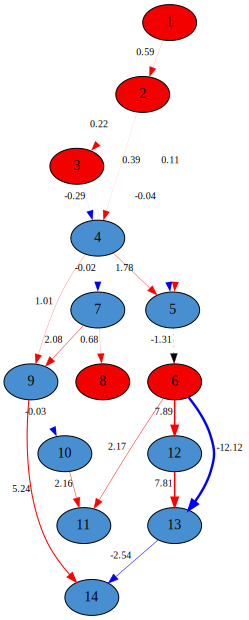

In [32]:
# display Graph
import graphviz

layout_engines = ["dot"]
original_filename = "./outputs/jupyter_test.dot"
final_filename = "./outputs/jupyter_res1.pdf"
nx.drawing.nx_pydot.write_dot(g, original_filename)
g
cmd_line = "neato -n -Tpdf " + original_filename + " -o " + final_filename
print("we print the cmd line = ", cmd_line)
os.system(cmd_line)
#os.system("evince " + final_filename + " &")

# this is the command line to create a pdf from a dot file, with fixed nodes
# neato - n2 - Tgif file.dot - o file.gif

for layout in layout_engines:
    filename = "./graph_results/pywpow_graph_" + layout + ".dot"
    gg = graphviz.Source.from_file(original_filename, engine=layout)
    ##gg.view(filename=filename)
gg

# REPRESENTATION GEOGRAPHIQUE

In [33]:
from IPython.display import IFrame

IFrame("./outputs/jupyter_res1.pdf", width=800, height=700)

# <font color=orange>4) Identify Local Electrical Paths</font>

In [34]:
# Let us add here a final test
print("This is our final test")

This is our final test
